# Garbage Detection

In [10]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import zipfile
import os
from imutils import paths
import argparse
from sklearn.preprocessing import LabelBinarizer
import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications import MobileNetV2, ResNet101
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, Dense, Input,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
import cv2

### References

https://pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/

https://shreyash1811.github.io/python/Garbage_classification/

## Dataset
We're using Trashnet. 
Found here: https://github.com/garythung/trashnet

In [11]:
# import dataset
zip_ref = zipfile.ZipFile('dataset-resized.zip', 'r') #r stands for read mode
zip_ref.extractall('/tmp') 
zip_ref.close()
# os.remove('/tmp/dataset-resized/.DS_Store')

In [12]:
len(os.listdir('/dataset-resized/blackbin/')) # testing dataset to make sure conneted

FileNotFoundError: [Errno 2] No such file or directory: '/dataset-resized/blackbin/'

In [ ]:
#Variables
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# loop over the image paths and append to arrays
data = []
label = []
imagePath = os.listdir('/tmp/dataset-resized')
for directoryPath in imagePath:
  path = os.path.join('/tmp/dataset-resized',directoryPath)
  for img in os.listdir(path):
    labelImage = directoryPath
    image = load_img(os.path.join(path,img), target_size=(300, 300))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    label.append(labelImage)

In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest",
    validation_split=0.2
)
validate_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_data = train_generator.flow_from_directory(
    directory= '/tmp/dataset-resized',
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)
validation_data = validate_generator.flow_from_directory(
    directory= '/tmp/dataset-resized',
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)
label = (train_data.class_indices)

Found 7520 images belonging to 4 classes.
Found 1878 images belonging to 4 classes.


In [ ]:
base= MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(300,300, 3)), input_shape = (300,300, 3))

In [ ]:
#  make the head
inputs = Input(shape=(300,300,3))
# extra convolution layers to fine-tune the network
head = base.output
head  = Conv2D(32,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head  = Conv2D(64,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head  = Conv2D(32,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head = Flatten()(head)
head = Dense(64, activation="relu")(head)
head = Dense(4, activation="softmax")(head)

In [ ]:
model = Model(inputs=base.inputs, outputs=head)

In [ ]:
print("[INFO] compiling model...")
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

#validates ad correct behaviours

checkpoints = ModelCheckpoint(
    filepath='models',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

early_stop = EarlyStopping(monitor='loss', patience=3)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

[INFO] compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                 

In [ ]:

# train the head of the network
print("[INFO] training head...")
garbageModel = model.fit(
    train_data,
    validation_data = validation_data,
    epochs=15,
    batch_size=16, 
    callbacks=[reduce, checkpoints, early_stop]
)

[INFO] training head...
Epoch 1/15
470/470 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.6453

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 131s 267ms/step - loss: 0.9201 - accuracy: 0.6453 - val_loss: 1.8796 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 2/15
470/470 [==============================] - 92s 195ms/step - loss: 0.6930 - accuracy: 0.7484 - val_loss: 2.3990 - val_accuracy: 0.3994 - lr: 0.0010
Epoch 3/15
470/470 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7915

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 104s 221ms/step - loss: 0.5899 - accuracy: 0.7915 - val_loss: 1.7844 - val_accuracy: 0.5069 - lr: 0.0010
Epoch 4/15
470/470 [==============================] - 93s 197ms/step - loss: 0.5069 - accuracy: 0.8247 - val_loss: 5.6053 - val_accuracy: 0.3711 - lr: 0.0010
Epoch 5/15
470/470 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.8443
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
470/470 [==============================] - 90s 192ms/step - loss: 0.4648 - accuracy: 0.8443 - val_loss: 12.4007 - val_accuracy: 0.4026 - lr: 0.0010
Epoch 6/15
470/470 [==============================] - 96s 205ms/step - loss: 0.2789 - accuracy: 0.9017 - val_loss: 7.9304 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 7/15
470/470 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9176
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
470/470 [=============================

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 102s 216ms/step - loss: 0.2252 - accuracy: 0.9273 - val_loss: 0.7185 - val_accuracy: 0.8397 - lr: 1.0000e-05
Epoch 9/15
470/470 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9219

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 106s 226ms/step - loss: 0.2248 - accuracy: 0.9219 - val_loss: 0.2835 - val_accuracy: 0.9201 - lr: 1.0000e-05
Epoch 10/15
470/470 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9328

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 104s 221ms/step - loss: 0.2076 - accuracy: 0.9328 - val_loss: 0.2417 - val_accuracy: 0.9127 - lr: 1.0000e-05
Epoch 11/15
470/470 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9322

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 103s 219ms/step - loss: 0.1976 - accuracy: 0.9322 - val_loss: 0.2394 - val_accuracy: 0.9084 - lr: 1.0000e-05
Epoch 12/15
470/470 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9320

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 104s 221ms/step - loss: 0.2054 - accuracy: 0.9320 - val_loss: 0.2288 - val_accuracy: 0.9121 - lr: 1.0000e-05
Epoch 13/15
470/470 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9350

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 104s 220ms/step - loss: 0.1980 - accuracy: 0.9350 - val_loss: 0.2160 - val_accuracy: 0.9159 - lr: 1.0000e-05
Epoch 14/15
470/470 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9356

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


470/470 [==============================] - 103s 218ms/step - loss: 0.1958 - accuracy: 0.9356 - val_loss: 0.2137 - val_accuracy: 0.9191 - lr: 1.0000e-05
Epoch 15/15
470/470 [==============================] - 96s 204ms/step - loss: 0.1909 - accuracy: 0.9368 - val_loss: 0.2210 - val_accuracy: 0.9137 - lr: 1.0000e-05


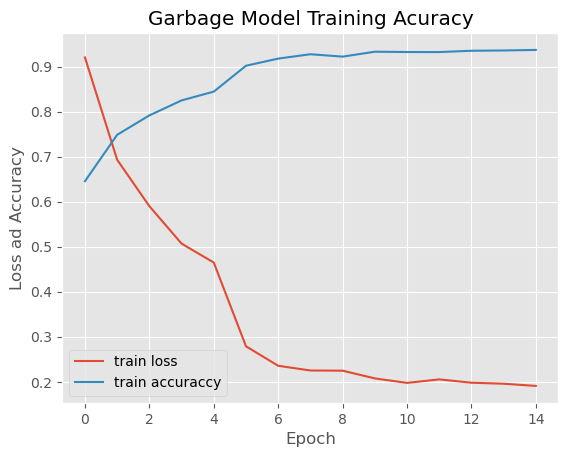

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), garbageModel.history["loss"], label="train loss")
plt.plot(np.arange(0, 15), garbageModel.history["accuracy"], label="train accuraccy")
plt.title("Garbage Model Training Acuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss ad Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


-batch sizes
-optomizer: could use rms prop
-tune hyperparameters 
-calllbacks? Early stopping, model checkpoint, tensorborad , reduceRonplateu
-callbacks after compile but before fit
-stratify
-adding that thing so everytime some layer doesn't change?

Found 9398 files belonging to 4 classes.
Using 7519 files for training.
['blackbin', 'bluebin', 'compost', 'garbage']


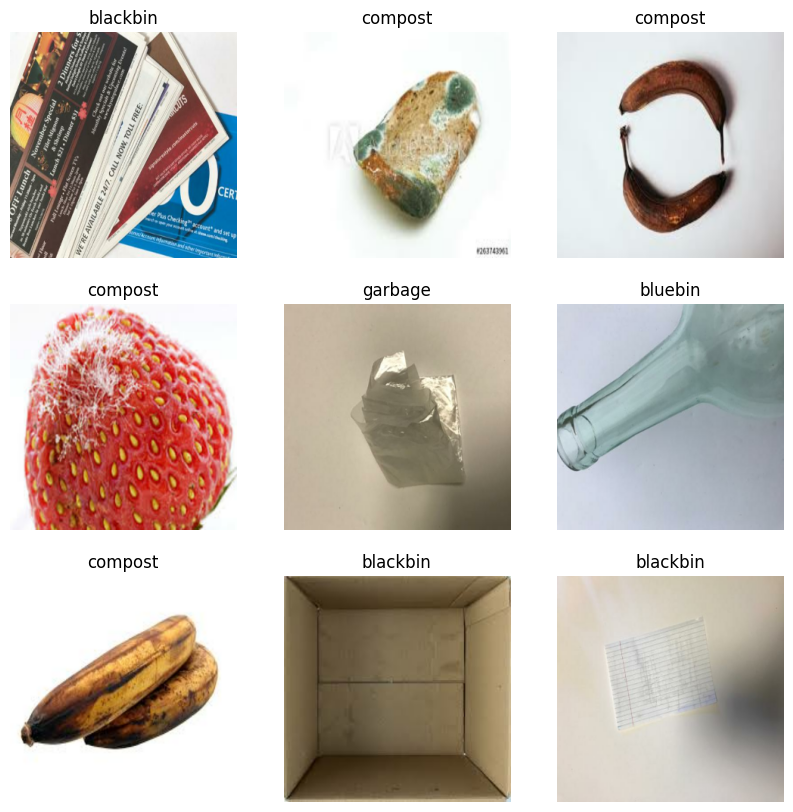

In [ ]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory= '/tmp/dataset-resized',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(300, 300),
  batch_size=16)
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
model.predict('/tmp/card.jpg')

NameError: name 'model' is not defined